# Testing full pipeline

In [1]:
%load_ext autoreload
%autoreload 2
from network_metrics import *
from network_viz import draw_network

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
mentor_matching.set_seed('beta')

In [10]:
nruns = 200
names_df = pd.read_csv('data/beta/names.csv')
mentees_df = pd.read_csv('data/beta/mentees.csv')
mentors_df = pd.read_csv('data/beta/mentors.csv')

metrics = [

    {'function': run_frac_mentees_less_than_requested,    'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_assigned_mentees,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_with_extra_slots,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentees_atleast_one_preference, 'weight': 1, 'type':'maximize', 'normalize':False},

    #{'function': run_mean_clique_size,                    'weight': 2, 'type':'maximize', 'normalize':True},
    #{'function': run_n_cliques_gt2,                       'weight': 1, 'type':'maximize', 'normalize':True},
    {'function': run_frac_mentees_alternatives,           'weight': 1, 'type':'minimize', 'normalize':False},
    {'function': run_network_modularity,                  'weight': 3, 'type':'maximize', 'normalize':True}
]

output = create_best_network(
    nruns,
    names_df,
    mentees_df,
    mentors_df,
    metrics,
    nbest = 10,
    combine_metric_method='multiply')

print("best:", output['best']['combined_metric'])
for i in range(len(output['bestlist'])-1):
    print("next bests", i+1, ":", output['bestlist'][i+1]['combined_metric'])

best: 0.0025
next bests 1 : 0.002014814814814814
next bests 2 : 0.0018666666666666664
next bests 3 : 0.001807407407407407
next bests 4 : 0.0016160493827160492
next bests 5 : 0.0015703703703703685
next bests 6 : 0.001503703703703703
next bests 7 : 0.0014814814814814805
next bests 8 : 0.0014444444444444446
next bests 9 : 0.0014395061728395058


In [11]:
import mentor_matching

best network values:
frac_mentees_less_than_requested : 0.0
frac_mentors_assigned_mentees : 1.0
frac_mentors_with_extra_slots : 0.75
frac_mentees_atleast_one_preference : 0.5
frac_mentees_alternatives : 0.3333333333333333
network_modularity : 0.56


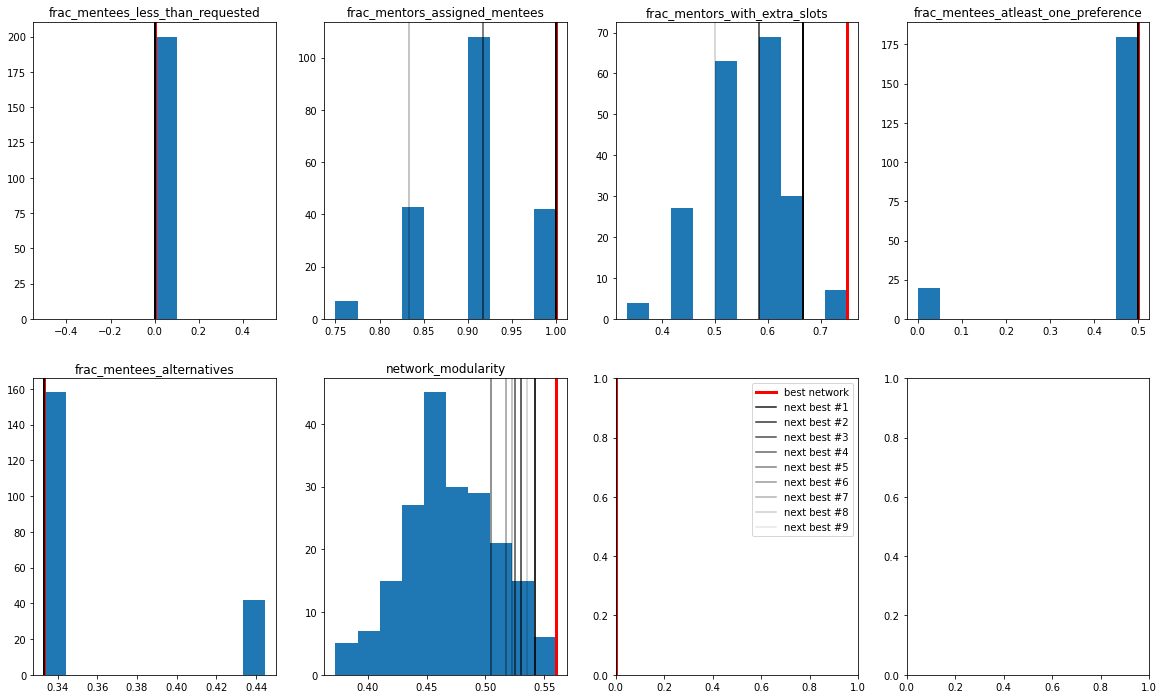

In [12]:
# plot all the metrics
nc = 4
nr = int(np.ceil(len(metrics)/nc))
fig,axs = plt.subplots(nr, nc, figsize = (20,12))
for i,ax in enumerate(axs.flatten()):
    if (i < len(metrics)):
        ax.hist(output['raw_metrics'][i], align = 'mid')
        ax.set_title(output['metric_names'][i])
        ax.axvline(output['raw_metrics'][i][output['best']['index']], color = 'red', lw = 3, label = 'best network')
        for ib in range(len(output['bestlist'])-1):
            ax.axvline(output['raw_metrics'][i][output['bestlist'][ib+1]['index']], color = 'black', lw = 1.5, alpha = (1.0-(ib+1)/10), label = 'next best #%d' %(ib+1))
    if i == len(metrics):
        ax.axvline(0, color = 'red', lw = 3, label = 'best network')
        for ib in range(len(output['bestlist'])-1):
            ax.axvline(0, color = 'black', lw = 1.5, alpha = (1.0-(ib+1)/10), label = 'next best #%d' %(ib+1))
        ax.legend()
        
print ("best network values:")
for i in range(len(metrics)):
    print(output['metric_names'][i], ':', output['raw_metrics'][i][output['best']['index']])

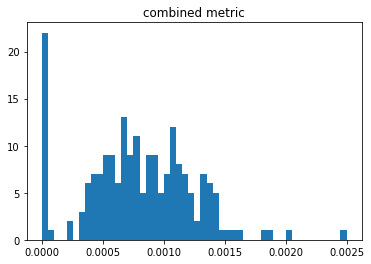

In [13]:
# plot the combined metric
f,ax = plt.subplots()
_ = ax.hist(output['combined_metric'], bins=50)
_ = ax.set_title('combined metric')

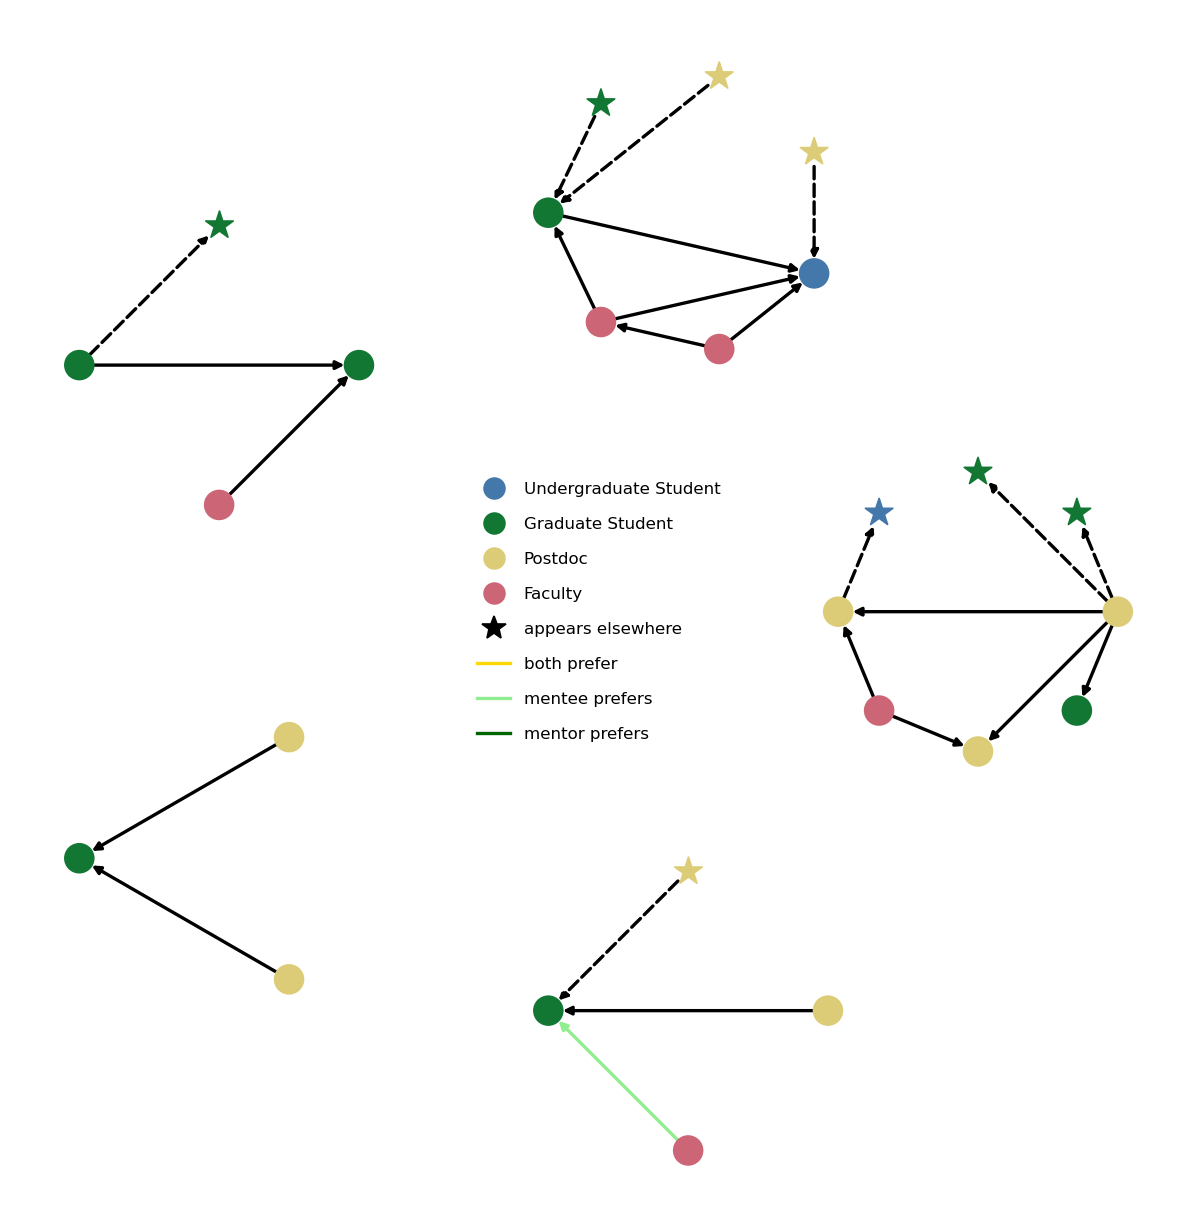

In [14]:
_ = draw_network(output['best']['network'])

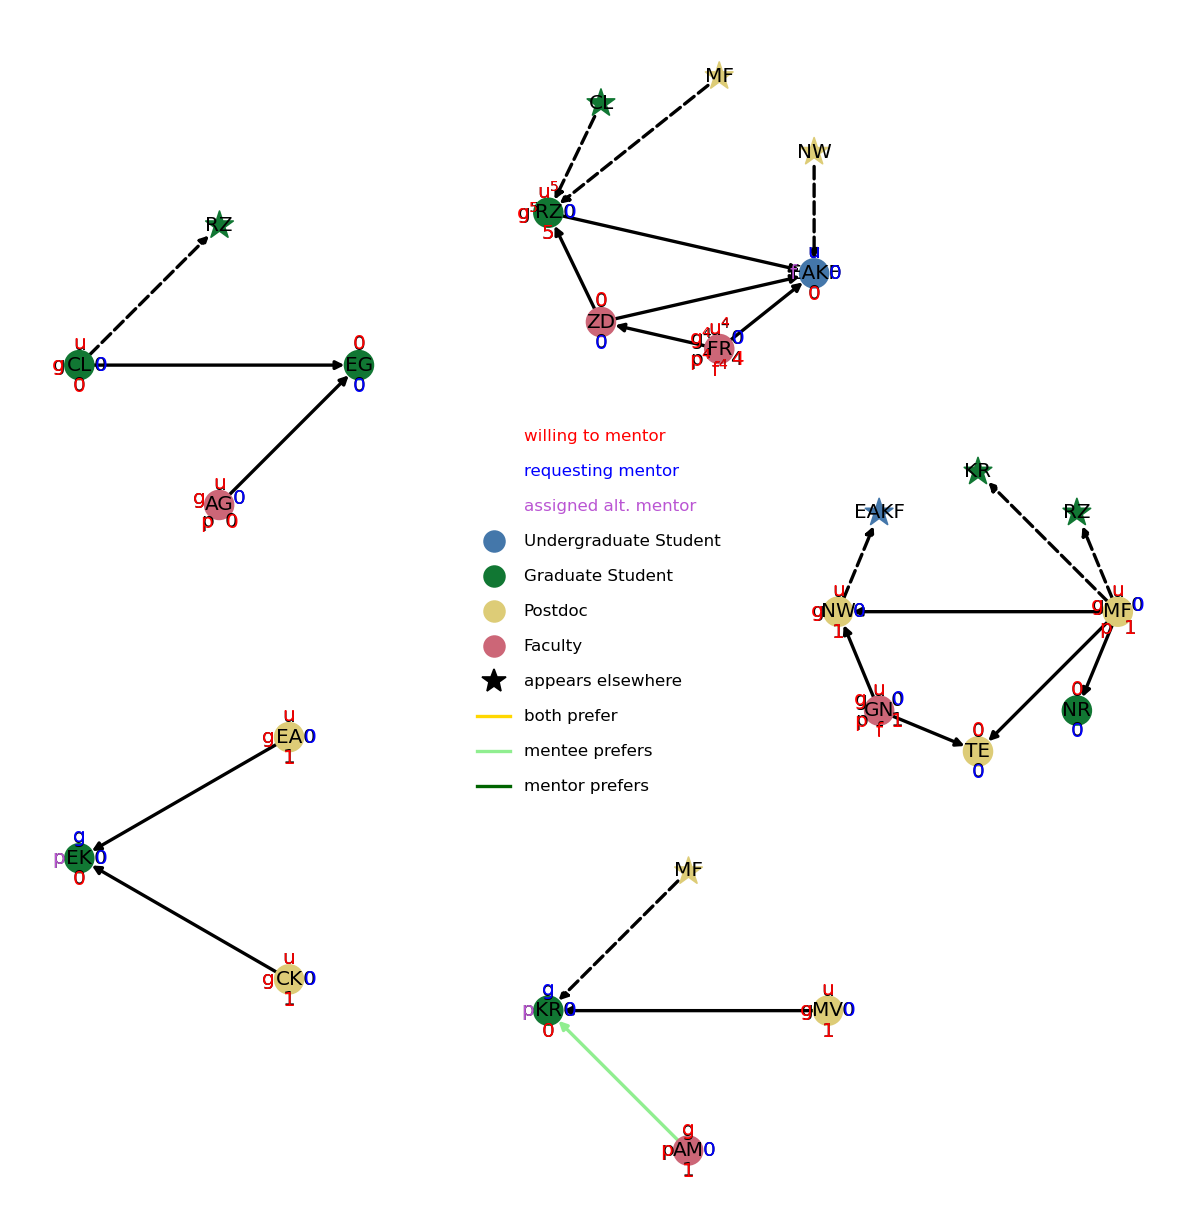

In [20]:
_ = draw_network(output['best']['network'],show_remaining_spots=True)

In [21]:
from network_viz import list_matches

In [22]:
matches = list_matches(output['best']['network'])

In [23]:
matches

['mentor Faculty: GilesNovak is matched to mentee Postdoc: TarranehEftekhari',
 'mentor Faculty: GilesNovak is matched to mentee Postdoc: NastashaWijers',
 'mentor Postdoc: MayaFishbach is matched to mentee Graduate Student: NabeelRehemtulla',
 'mentor Postdoc: MayaFishbach is matched to mentee Postdoc: NastashaWijers',
 'mentor Postdoc: MayaFishbach is matched to mentee Postdoc: TarranehEftekhari',
 'mentor Faculty: ZoheyrDoctor is matched to mentee Graduate Student: RachelZhang',
 'mentor Faculty: ZoheyrDoctor is matched to mentee Undergraduate Student: EliseuAntonioKlosterFilho',
 'mentor Graduate Student: RachelZhang is matched to mentee Undergraduate Student: EliseuAntonioKlosterFilho',
 'mentor Faculty: FredRasio is matched to mentee Faculty: ZoheyrDoctor',
 'mentor Faculty: FredRasio is matched to mentee Undergraduate Student: EliseuAntonioKlosterFilho',
 'mentor Graduate Student: CamilleLiotine is matched to mentee Graduate Student: ElenaGonzalez',
 'mentor Faculty: AaronGeller

# Scratch space below ...

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import networkx as nx

In [12]:
import pandas as pd

In [13]:
from mentor_matching import reduce_full_tables

In [14]:
names_df = pd.read_csv('data/alpha2/name_list.csv')
all_names = names_df.loc[:,::2].values.flatten()
for i in range(len(all_names)): 
    name = all_names[i]
    if type(name) == str:
        all_names[i] = name.replace(' ','')

## show just the first 5 rows
names_df.head()

,Faculty,Unnamed: 1,Postdoc,Unnamed: 3,Graduate Student,Unnamed: 5,Undergraduate Student,Unnamed: 7
0,Lilly Norton,NK,Christiana Buckner,NK,Subhaan Walsh,NK,Maira Nava,NK
1,Anand Coulson,AMG,Yusuf Lucas,NK,Amaan Terry,NK,Marius Beil,TS
2,Ruby-Leigh Holloway,AMG,Indigo Cope,TS,Brennan Stanton,TS,Khia Galindo,AMG
3,Kacie Chandler,NaN,Felicity Vo,TS,Quinn Cobb,AMG,Willem Swan,AMG
4,Iosif Chaney,NaN,Alexander Mitchell,AMG,Hannah Rivas,AMG,Harris Bryan,NaN


In [15]:
mentees_df = pd.read_csv('data/alpha2/mentees.csv')
#mentees_df.head()

In [16]:
mentors_df = pd.read_csv('data/alpha2/mentors.csv')
#mentors_df.head()

In [35]:
for person in people.values():
    if person.rank == 0:
        person.print_preferences()

Undergraduate Student: MairaNava
nmentors: 2 [1. 1. 0. 0.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: ['SubhaanWalsh']
------

Undergraduate Student: MariusBeil
nmentors: 5 [2. 1. 1. 1.]
nmentees: 1 [1. 0. 0. 0.] (1)
------
avoid  mentees: []
avoid  mentors: ['FelicityVo']
------
prefer mentees: []
prefer mentors: ['SaniaNorman', 'IndigoCope']
------

Undergraduate Student: KhiaGalindo
nmentors: 4 [1. 1. 1. 1.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: ['AlexanderMitchell']
------
prefer mentees: []
prefer mentors: ['AnandCoulson']
------

Undergraduate Student: WillemSwan
nmentors: 2 [1. 0. 0. 1.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Undergraduate Student: HarrisBryan
nmentors: 0 [0. 0. 0. 0.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []


--------

In [9]:
from mentor_matching import generate_network
from network_metrics import *

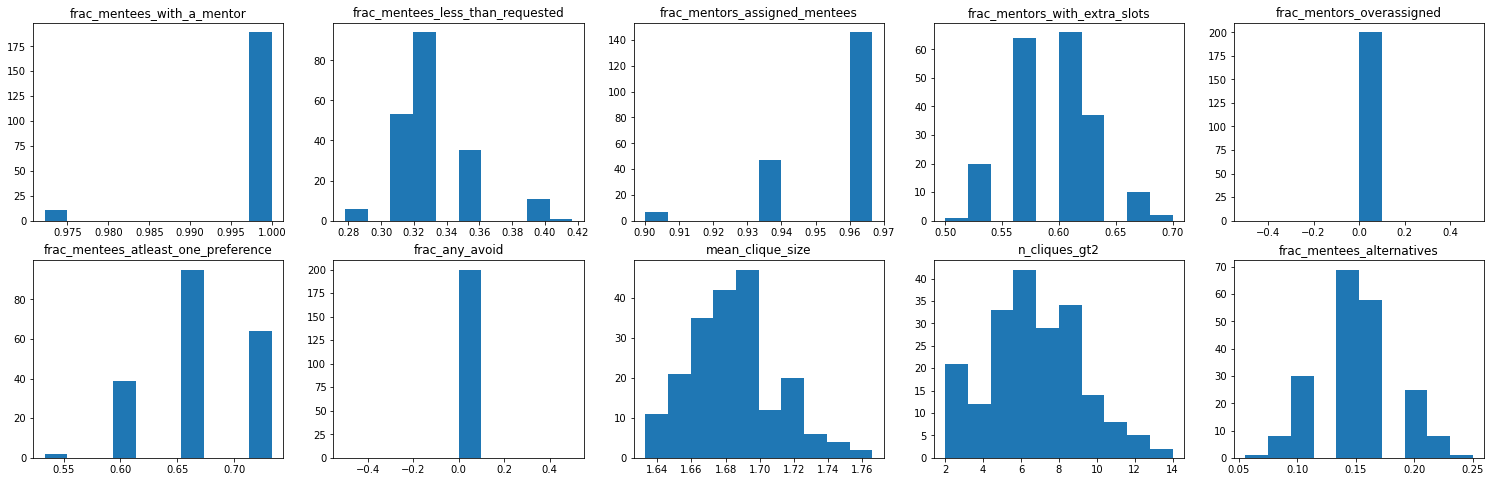

In [11]:
fig,axs = plt.subplots(nrows=2,ncols=5)
for i,ax in enumerate(axs.flatten()):
    if (i < len(vals)):
        ax.hist(vals[i], align = 'mid')
        ax.set_title(names[i])
fig.set_size_inches(26,8)

In [84]:
vals.shape

(10, 200)

In [58]:
# testing a method to pick the best network
# in order of vals array
# 0: (top) maximize frac_mentees_with_a_mentor
# 1: maximize frac_mentees_less_than_requested
# 2: maximize frac_mentors_assigned_mentees ?
# 3: maximize frac_mentors_with_extra_slots ?
# 4: (top) throw out any with frac_mentors_overassigned --> required check
# 5: maximize frac_mentees_atleast_one_preference
# 6: (top) throw out any with frac_any_avoid > 0 --> required check
# 7: (top) maximize mean_clique_size
# 8: maximize n_cliques_gt
# 9: minmize alternative mentor assignments

combined_metric = [0]*nruns
topfac = 2.
midfac = 1.
#for normalizing the clique size
def norm_n_metric(val, arr):
    return (val - min(arr))/(max(arr) - min(arr))

for i in range(nruns):
    #top priority
    top = vals[0, i]*norm_n_metric(vals[7, i], vals[7])
    if (vals[4, i] > 0 or vals[6, i] > 0):
        top = 0
        
    #less important
    mid = vals[1,i]*vals[2,i]*vals[3,i]*vals[5,i]*norm_n_metric(vals[8,i], vals[8])
    
    #sum (note: this is some combined multiply and weighted average method...)
    combined_metric[i] = (topfac*top + midfac*mid)/(topfac + midfac)

#just a check
best = [i for (i, x) in enumerate(combined_metric) if x > 0.5]
print(best)
print(combined_metric[best[0]])
print('N with combined_metric > 0.7', len(best))
the_best = networks[best[0]]

[164]
0.7122962962962963
N with combined_metric > 0.7 1


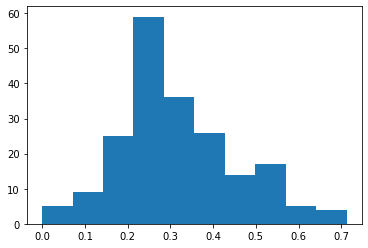

In [88]:
f, ax = plt.subplots()
_ = ax.hist(combined_metric)

In [85]:
# testing a method to pick the best network
# in order of vals array
# 0: (top) maximize frac_mentees_with_a_mentor
# 1: maximize frac_mentees_less_than_requested
# 2: maximize frac_mentors_assigned_mentees ?
# 3: maximize frac_mentors_with_extra_slots ?
# 4: (top) throw out any with frac_mentors_overassigned --> required check
# 5: maximize frac_mentees_atleast_one_preference
# 6: (top) throw out any with frac_any_avoid > 0 --> required check
# 7: (top) maximize mean_clique_size
# 8: maximize n_cliques_gt
# 9: minmize alternative mentor assignments

from network_metrics import *

metrics = [
    {'function': run_frac_mentees_with_a_mentor,          'weight': 2, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentees_less_than_requested,    'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_assigned_mentees,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_with_extra_slots,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_overassigned,           'weight': 1, 'type':'binary0',  'normalize':False},
    {'function': run_frac_mentees_atleast_one_preference, 'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_any_avoid,                      'weight': 1, 'type':'binary0',  'normalize':False},
    {'function': run_mean_clique_size,                    'weight': 2, 'type':'maximize', 'normalize':True},
    {'function': run_n_cliques_gt2,                       'weight': 1, 'type':'maximize', 'normalize':True},
    {'function': run_frac_mentees_alternatives,           'weight': 1, 'type':'minimize', 'normalize':False},
]

multiply_metrics = run_weighted_metrics(people_list, network_list, metrics, method='multiply')
add_metrics = run_weighted_metrics(people_list, network_list, metrics, method='mean')

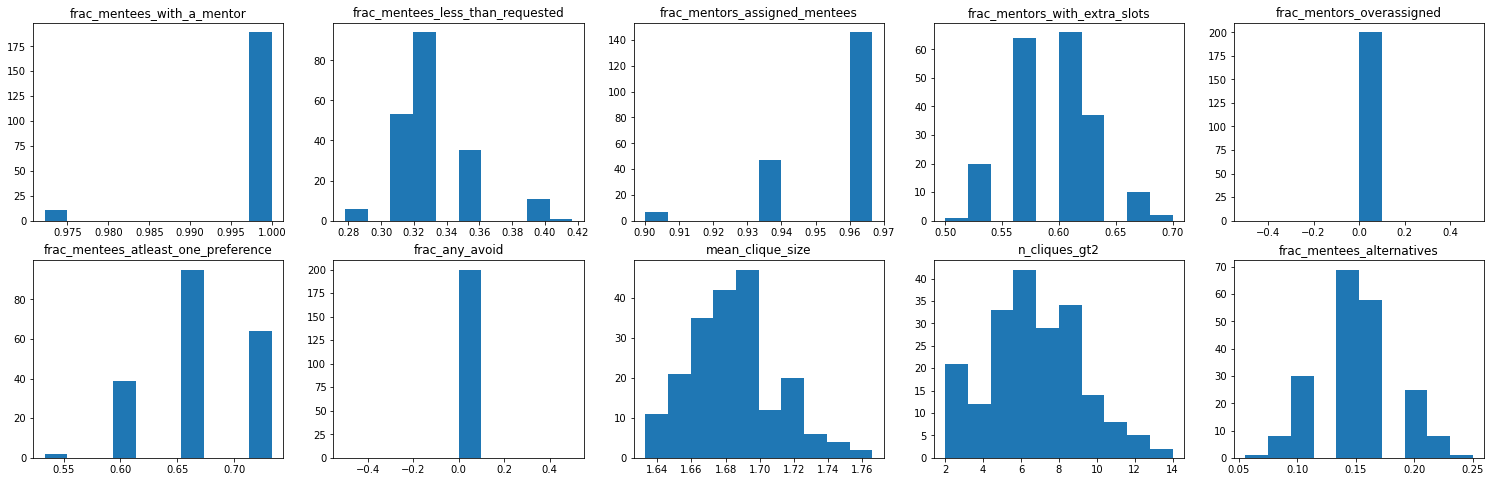

In [86]:
nc = 5
nr = int(np.ceil(len(metrics)/nc))
fig,axs = plt.subplots(nrows = nr, ncols = nc)
for i,ax in enumerate(axs.flatten()):
    if (i < len(metrics)):
        ax.hist(multiply_metrics['raw_metrics'][i], align = 'mid')
        ax.set_title(multiply_metrics['metric_names'][i])
fig.set_size_inches(26,8)

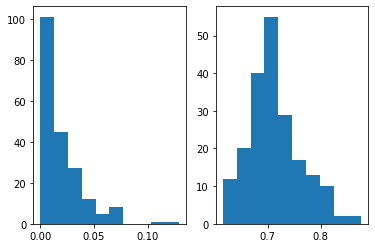

In [87]:
f, ax = plt.subplots(1, 2)
_ = ax[0].hist(multiply_metrics['combined_metric'])
_ = ax[1].hist(add_metrics['combined_metric'])